https://github.com/shivamsingh96/Facial-Expression-Detection-using-CNN-Real-Time-Recognition-with-Webcam/blob/main/Real-Time%20Facial%20Expression%20Detection%20%26%20Recognition%20using%20CNN.ipynb

## 0. Notebook description



Generative Adversarial Networks (GANs) are a class of machine learning models designed to generate new data that resembles a given dataset. 

They consist of two components: a **generator** and a **discriminator**, which work in opposition. The generator creates synthetic data (e.g., images), while the discriminator attempts to distinguish between real and generated data. Through this adversarial process, both models improve, with the generator learning to produce increasingly realistic data.

In this notebook, we will use a GAN to enrich the FER2013 dataset. By generating additional images for each emotion class, we aim to improve the diversity of training data. This augmentation can enhance the performance of machine learning models trained on the dataset, especially in tasks like facial expression recognition. 




## 1. Importing libraries and loading the data

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import pandas as pd
import torchvision.utils as vutils

from sklearn.model_selection import train_test_split

First, we load the data into a pandas dataframe.

In [2]:
train_unprocessed= pd.read_csv("data/train.csv")
print(train_unprocessed.head(10))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
9        2  255 254 255 254 254 179 122 107 95 124 149 150...


## 2. Data preparation

Because the dataset is imbalanced, we will provide the GAN with equal quantities of each label by oversampling our data, as in previous notebooks.

In [8]:
# Split the data into feature & target variable
x_data = train_unprocessed['pixels']
y_data = train_unprocessed['emotion']

oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)

# Convert oversampled data back to a DataFrame for compatibility with the dataset
x_data = pd.DataFrame(x_data, columns=["pixels"])
y_data = pd.Series(y_data, name="emotion")
oversampled_data = pd.concat([x_data, y_data], axis=1)

# Shuffle the oversampled dataset to mix the examples
oversampled_data = shuffle(oversampled_data)

print(oversampled_data.shape)
print(oversampled_data['emotion'].value_counts())

(50505, 2)
emotion
4    7215
2    7215
6    7215
0    7215
5    7215
1    7215
3    7215
Name: count, dtype: int64


As in previous notebooks, we also apply the following preprocessing steps to convert the data into the format the GAN can use:
1. **Reshaping**:
   - Convert the pixel string into a `48x48` matrix for visualization and processing.
2. **Scaling**:
   - Scale pixel values to the range `[0, 1]` by dividing the pixel values by 255.
3. **Normalization**:
   - Normalize pixel values to the range `[-1, 1]` by subtracting the mean and diving them by the standard deviation.

In [9]:
class ReshapeAndScale:
    def __init__(self, n_rows, n_cols):
        self.n_rows = n_rows
        self.n_cols = n_cols

    def __call__(self, pixel_string):
        # Reshape the flat pixel string into a 2D array
        pixel_vals = np.array([float(val) for val in pixel_string.split()], dtype=np.float32)
        image = pixel_vals.reshape(self.n_rows, self.n_cols)

        # Scale the image to [0, 1]
        image = image / 255.0

        # Convert to a PyTorch tensor
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0) # add a channel dimension

# Define the pipeline
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

## 2. Define a custom dataset


For the purposes of this notebook, we redefine the FER2013Dataset class to allow for filtering by label, which we will use later to create our training loaders, used by each GAN (1 for each emotion) to make an image. 

Here is a breakdown of its new functionality:

1. **Initialization (`__init__` method)**:
   - The `_group_indices_by_label` method is called to organize the dataset indices by their labels, which facilitates label-specific operations.

2. **Grouping Indices by Label (`_group_indices_by_label` method)**:
   - This helper function creates a dictionary, `label_to_indices`, where each label maps to a list of indices corresponding to that label in the dataset.

3. **Filtering by Indices (`filter_by_indices` method)**:
   - Allows filtering the dataset to create a subset using specific indices.
   - Returns a new `Fer2013Dataset` instance containing the filtered data and labels while preserving the transformation function.




In [10]:
from torch.utils.data import Dataset

class Fer2013Dataset(Dataset):
    def __init__(self, data_frame, labels, transform=None):
        self.data_frame = data_frame
        self.labels = labels
        self.transform = transform
        self.label_to_indices = self._group_indices_by_label()

    def _group_indices_by_label(self):
        # Group indices of the dataset by their labels
        label_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(idx)
        return label_to_indices

    def filter_by_indices(self, indices):
        # Create a filtered dataset based on specific indices
        filtered_data = self.data_frame.iloc[indices]
        filtered_labels = self.labels.iloc[indices]
        return Fer2013Dataset(filtered_data, filtered_labels, self.transform)

    def __getitem__(self, idx):
        pixel_string = self.data_frame.iloc[idx]["pixels"]
        image = self.transform(pixel_string) if self.transform else pixel_string
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return image, label

    def __len__(self):
        return len(self.data_frame)

The following code demonstrates how to split a dataset into training and validation subsets using stratified sampling, then create data loaders for batch processing. Here's an explanation of each step:


1. **Dataset Initialization**:
   - A `Fer2013Dataset` object, `full_dataset`, is created using the oversampled data and its corresponding labels (`oversampled_data['emotion']`). 
   - An optional `transform` function is applied to preprocess the data.
   - The size of the full dataset is printed to verify its dimensions.

2. **Stratified Sampling**:
   - The dataset is split into training and validation subsets while maintaining the label distribution across both subsets (stratification).
   - This is achieved using the `train_test_split` function from scikit-learn:
     - `np.arange(len(full_dataset))` generates indices for all samples in the dataset.
     - `test_size=0.2` specifies that 20% of the data is reserved for validation.
     - `stratify=full_dataset.labels` ensures the label distribution in both subsets mirrors that of the full dataset.
     - `shuffle=True` and `random_state=999` guarantee reproducibility.

3. **Subset Creation**:
   - The `Subset` class is used to create two datasets:
     - `train_dataset`: Contains the samples corresponding to the indices in `train_idx`.
     - `validation_dataset`: Contains the samples corresponding to the indices in `validation_idx`.
   - The size of the training dataset is printed to confirm its dimensions.

4. **DataLoader Initialization**:
   - `DataLoader` objects are created to handle batching and shuffling of data during model training and evaluation:
     - `train_loader`: Loads data from the training subset in batches of size `batch_size` (32) and shuffles the data.
     - `val_loader`: Loads data from the validation subset in batches of size `batch_size`, without shuffling (to ensure consistent validation results).

These steps prepare the dataset for model training by organizing it into manageable batches while maintaining the label distribution in the train and validation sets. The use of `DataLoader` simplifies batch-wise data loading and iteration during the training process.



In [11]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

batch_size = 32

full_dataset = Fer2013Dataset(oversampled_data, oversampled_data['emotion'], transform=transform)
print("Full dataset size:", len(full_dataset))

# Stratified Sampling for train and val
train_idx, validation_idx = train_test_split(np.arange(len(full_dataset)),
                                             test_size=0.2,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=full_dataset.labels)

# Subset dataset for train and val
train_dataset = Subset(full_dataset, train_idx)
validation_dataset = Subset(full_dataset, validation_idx)


print("Train dataset size:", len(train_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)



Full dataset size: 50505
Train dataset size: 40404


## 3. Generate new images with GAN


In this section, we demonstrate how to generate new images using a Generative Adversarial Network (GAN) trained on the FER2013 dataset.  This process involves training a GAN model with the FER2013 dataset, enabling it to learn the distribution of the image data and generate new samples. 

We hope to use the generated images to improve model performance, address data imbalance, or explore the capabilities of GANs in facial expression generation.

We adapt the PyTorch GAN tutorial to be used on 48 by 48 grayscale images. 




In [12]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


We create training loaders to load examples of each label to train the GAN. 

In [13]:
def create_loaders():
    dataset_loaders = {}
    for label_no, desc in emotion_labels.items():
        print("Creating loader for data with label ", label_no)
        
        train_indices = train_dataset.indices 
        train_labels = full_dataset.labels.iloc[train_indices]

        filtered_indices = [idx for idx, label in zip(train_indices, train_labels) if label == label_no]

        filtered_train_dataset = full_dataset.filter_by_indices(filtered_indices)
        print("Number of examples in dataset:", len(filtered_train_dataset))
        filtered_train_loader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True)
        dataset_loaders[label_no] = filtered_train_loader
    return dataset_loaders

### Explanation of Variables in the GAN Training Process

#### Data Loading and Preprocessing
- **`workers`**: The number of worker threads used by the DataLoader to load data in parallel. This optimizes data loading speed during training.
- **`batch_size`**: The number of samples processed together in a single forward and backward pass. It affects memory usage and training stability.
- **`image_size`**: The spatial dimensions (height and width) of the training images. All input images are resized to this size, which is \(48 x 48\) pixels for the FER2013 dataset.
- **`nc`**: The number of channels in the training images. For grayscale images, this is 1. For RGB images, it would be 3.

#### GAN Architecture Hyperparameters
- **`nz`**: The size of the latent vector \(z\), which is the input noise to the generator. This vector is randomly sampled and serves as the basis for generating new images.
- **`ngf`**: The number of feature map channels in the generator. It determines the generator's capacity to model complex patterns in the data.
- **`ndf`**: The number of feature map channels in the discriminator. A higher value enables the discriminator to better distinguish between real and generated images.

#### Training Hyperparameters
- **`num_epochs`**: The total number of training epochs, where one epoch is a complete pass through the dataset. Higher values generally lead to better-trained models.
- **`lr`**: The learning rate for the optimizers. It controls the step size for updating model weights. A lower learning rate ensures more stable convergence.
- **`beta1`**: A hyperparameter for the Adam optimizer that determines the exponential decay rate for the first moment estimates. A value of 0.5 is commonly used for GANs to stabilize training.
- **`ngpu`**: The number of GPUs available for training. Setting this to 0 runs the code on a CPU, while a positive value enables GPU acceleration for faster computation.

#### Model Saving
- **`PATH`**: The naming convention for saving the trained model. It includes placeholders for the epoch number, model name, and emotion label.





In [14]:

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 48

# Number of channels in the training images. For black-and-white images this is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

PATH="{epoch}-{modelname}-label-{emotion}.pth"

In [15]:
# custom weights initialization called on `netG` and `netD`
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### 3a. Define the Generator class

The `Generator` class defines the generator component of a GAN, which is responsible for creating synthetic images from a random noise vector \(z\). It uses transposed convolutional layers (`nn.ConvTranspose2d`) to progressively upsample the input and generate a \(48 x 48\) grayscale image. 

Key components of the architecture:
- **Input**: The latent vector \(z\) with dimensions specified by `nz`. This vector represents random noise sampled from a distribution.
- **Upsampling Layers**: The generator consists of a series of transposed convolutional layers, each increasing the spatial dimensions of the data while reducing the depth (number of feature maps). 
- **Feature Map Sizes**: The feature maps start with a depth of `ngf * 8` at a small spatial size (3 x 3) and are gradually scaled up to the final image size \(48 x 48) with `nc` channels.

- **Batch Normalization**: Each layer (except the final one) includes batch normalization (`nn.BatchNorm2d`) to stabilize the learning process and improve convergence.
- **Activation Functions**:
  - **ReLU (`nn.ReLU`)** is used in the hidden layers to introduce non-linearity, allowing the generator to learn complex patterns.
  - **Tanh (`nn.Tanh`)** is applied to the output layer, ensuring pixel values are in the range \([-1, 1]\), which is compatible with normalized image data.

The `forward` method defines the forward pass of the generator, where the latent vector is transformed through the defined sequence of layers to produce an image.


In [16]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ngf*8) x 3 x 3
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ngf*4) x 6 x 6
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ngf*2) x 12 x 12
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size: (ngf) x 24 x 24
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 48 x 48
        )

    def forward(self, input):
        return self.main(input)

#### 3b. Define the discriminator class
The `Discriminator` class defines the discriminator component of a GAN, which is responsible for evaluating whether an input image is real (from the dataset) or fake (generated by the generator). It uses a series of convolutional layers to downsample the input image, progressively extracting features and reducing its spatial dimensions, ultimately producing a single output value between 0 and 1.

Key features of the architecture:
- **Input**: The discriminator takes an image of size \(48 x 48\) with `nc` channels (e.g., 1 for grayscale images).
- **Downsampling Layers**: The network consists of convolutional layers (`nn.Conv2d`) that reduce the spatial dimensions of the image while increasing the depth of feature maps.
- **Feature Map Sizes**: The input passes through several layers where the feature map size starts at `ndf` and increases up to `ndf * 8` as the spatial dimensions are reduced to \(3 x 3\).

- **Batch Normalization**: Batch normalization layers (`nn.BatchNorm2d`) are included (except for the first and last layers) to stabilize training and improve convergence.
- **Activation Functions**:
  - **LeakyReLU (`nn.LeakyReLU`)**: Used after most convolutional layers to introduce non-linearity while allowing a small gradient flow for negative inputs, improving gradient flow stability.
  - **Sigmoid (`nn.Sigmoid`)**: Applied in the final layer to output a value between 0 and 1, representing the discriminator's confidence that the input is real.

The `forward` method defines the forward pass, where the input image is transformed through the layers to produce a single scalar output. This scalar indicates whether the input is classified as real (close to 1) or fake (close to 0).


In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 48 x 48
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # (ndf) x 24 x 24
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # (ndf*2) x 12 x 12
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # (ndf*4) x 6 x 6
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # (ndf*8) x 3 x 3
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),  # 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

#### 3c. Define the functions used in our training and generation loop

The `get_image_tensors` function generates a specified number of synthetic images using a trained GAN generator. It processes images in batches for efficiency:

1. **Setup**: Calculates the number of batches (`num_batches`) needed and initializes an empty list (`image_tensors`) to store generated images.
2. **Batch-wise Generation**:
   - For each batch, random latent vectors (`noise`) are sampled from a normal distribution.
   - The generator model produces fake images, which are detached from the computation graph and stored in `image_tensors`.
   - The batch size is adjusted for the final batch to ensure the exact number of images is generated.
3. **Return**: The function prints the total images generated and returns `image_tensors`, a list of tensors, each containing a batch of generated images.

Each image is of size \(nc, 48, 48)\, where `nc` is the number of channels. 

In [18]:
def get_image_tensors(model, total_images=2000):
    image_tensors=[]
    num_batches = (total_images + batch_size - 1) // batch_size  # Ceiling division
    image_counter = 0

    print("Generating images...")
    for batch_idx in range(num_batches):

        # Adjust batch size for the last batch
        current_batch_size = min(batch_size, total_images - image_counter)
        
        # Generate latent vectors
        noise = torch.randn(current_batch_size, nz, 1, 1, device=device)
        
        # Generate images
        with torch.no_grad():
            fake_images = model(noise).detach().cpu()  # `fake_images` has shape (batch_size, nc, 48, 48)
            image_tensors.append(fake_images)
        
        image_counter += current_batch_size
    print(f"Generated {image_counter}/{total_images} images")
    return image_tensors

The function `create_and_train_gan` defines our training loop for our GAN, specifically designed to generate images for a single emotion label. It involves training both the **Generator** and **Discriminator** networks using the standard adversarial training approach.

### Steps:

1. **Setup**:
   - **Generator (`netG`) and Discriminator (`netD`) Creation**: Both networks are created and moved to the appropriate device (CPU or GPU). If multiple GPUs are available, the models are wrapped in `nn.DataParallel` for parallel processing.
   - **Weight Initialization**: The `weights_init` function is applied to randomly initialize the weights of both networks.
   - **Loss Function**: The `BCELoss` function is used for binary classification, where the Discriminator predicts whether an image is real or fake.

2. **Optimizers**:
   - Adam optimizers are set up for both the Generator (`optimizerG`) and Discriminator (`optimizerD`) with a learning rate (`lr`) and beta values for momentum.

3. **Training Loop**:
   - The loop runs for a specified number of epochs (`num_epochs`), and in each epoch, it iterates through batches of real images from the `train_loader`.

4. **Training the Discriminator**:
   - **Real Batch**: The Discriminator is first trained on a batch of real images. The target labels for these images are set to 1 (real). The loss is computed as the difference between the Discriminator's output and the real label. The gradients are then backpropagated.
   - **Fake Batch**: The Discriminator is then trained on a batch of fake images generated by the Generator. The target labels for these are set to 0 (fake). Again, the loss is calculated and gradients are backpropagated.

5. **Training the Generator**:
   - The Generator is updated to improve its ability to fool the Discriminator. It is trained using fake images generated from random latent vectors, but this time the target label is set to 1 (real), as the Generator wants the Discriminator to classify its fake images as real.
   - The loss for the Generator is computed based on the Discriminator's output for the fake images.

6. **Loss Output and Saving Checkpoints**:
   - Every 50 iterations, the current loss values for both networks are printed for monitoring the training process.
   - At the end of each epoch, the model weights for both the Generator and Discriminator are saved using `torch.save`.

### Final output:
- After training, the function returns the trained Generator model (`netG`), which can be used to generate new images based on latent vectors.


In [20]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
def create_and_train_gan(train_loader, label_no):

    # Create the generator
    netG = Generator(ngpu).to(device)
    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))
    
    # Apply the `weights_init` function to randomly initialize all weights
    netG.apply(weights_init)

    # Create the Discriminator
    netD = Discriminator(ngpu).to(device)

    # Initialize the `BCELoss` function
    criterion = nn.BCELoss()
    

    
    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
    
    # Apply the `weights_init` function to randomly initialize all weights
    netD.apply(weights_init)
    
    
    # Training Loop
    
    iters = 0    
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(train_loader, 0):
    
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
    
            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
    
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
    
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(train_loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
            # # Save Losses for plotting later
            # G_losses.append(errG.item())
            # D_losses.append(errD.item())
    
            # # Check how the generator is doing by saving G's output on fixed_noise
            # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            #     with torch.no_grad():
            #         fake = netG(fixed_noise).detach().cpu()
            #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
            iters += 1
        torch.save(netG.state_dict(), 
                   PATH.format(epoch=str(epoch), modelname="generator", emotion=str(label_no)))
        torch.save(netD.state_dict(), 
                   PATH.format(epoch=str(epoch), modelname="discriminator", emotion=str(label_no)))
    return netG


- The function `create_images_by_label` trains a separate GAN for each emotion label in the dataset, generates synthetic images, and stores them in a dictionary, where each key corresponds to an emotion label and each value is a list of generated image batches.



1. **Initialization**:
   - **`image_tensor_batches`**: An empty dictionary to store the generated image batches for each label. The keys are the label numbers, and the values are lists of image tensors.
   - **`loaders_by_label`**: This variable is created by calling the `create_loaders` function, which likely generates separate data loaders for each emotion label in the dataset.

2. **Looping Through Labels**:
   - For each label in `loaders_by_label` (which contains the emotion labels as keys and the corresponding data loaders as values), the function performs the following:
     - Prints the current label number and its associated emotion name using the `emotion_labels` dictionary.
     - Calls the `create_and_train_gan` function to create and train a GAN model on the current label's data loader. The resulting trained generator is added to the `generators_dict` under the current label's number.
     - Calls the `get_image_tensors` function with the trained generator to generate synthetic images. This function returns a list of image tensors, which are stored in `image_tensors_list`.
     - Prints an example image (the last batch generated) from `image_tensors_list` for visual inspection.
     - Adds the list of generated image tensors (`image_tensors_list`) to `image_tensor_batches`, using the current label number as the key.

3. **Return**:
   - After processing all labels, the function returns `image_tensor_batches`, which contains a dictionary of generated image batches for each emotion label.


In [21]:
def create_images_by_label(generators_dict):
    image_tensor_batches = {}
    loaders_by_label = create_loaders()  
    for label_no, loader in loaders_by_label.items():
        print("Training model for label:", label_no, emotion_labels[label_no])
        generator = create_and_train_gan(loader, label_no)
        generators_dict[label_no] = generator
        image_tensors_list = get_image_tensors(generator)
        print("Example image:",image_tensors_list[-1])
        image_tensor_batches[label_no] = image_tensors_list
    return image_tensor_batches

Below, we start our training loop.

In [22]:
labels_generators = {}
image_tensors = create_images_by_label(labels_generators)

Creating loader for data with label  0
Number of examples in dataset: 5772
Creating loader for data with label  1
Number of examples in dataset: 5772
Creating loader for data with label  2
Number of examples in dataset: 5772
Creating loader for data with label  3
Number of examples in dataset: 5772
Creating loader for data with label  4
Number of examples in dataset: 5772
Creating loader for data with label  5
Number of examples in dataset: 5772
Creating loader for data with label  6
Number of examples in dataset: 5772
Training model for label: 0 Angry
Starting Training Loop...
[0/300][0/181]	Loss_D: 1.6593	Loss_G: 5.2483	D(x): 0.6765	D(G(z)): 0.6678 / 0.0065
[0/300][50/181]	Loss_D: 0.2651	Loss_G: 9.6788	D(x): 0.8982	D(G(z)): 0.1182 / 0.0001
[0/300][100/181]	Loss_D: 1.0533	Loss_G: 8.3023	D(x): 0.5140	D(G(z)): 0.0034 / 0.0015
[0/300][150/181]	Loss_D: 0.4847	Loss_G: 4.7181	D(x): 0.7691	D(G(z)): 0.1554 / 0.0120
[1/300][0/181]	Loss_D: 0.4525	Loss_G: 4.3424	D(x): 0.8075	D(G(z)): 0.1285 / 0.

## 4. Inspect images

In this section, we visualize the images created by the GAN. 

ValueError: num must be an integer with 1 <= num <= 100, not 101

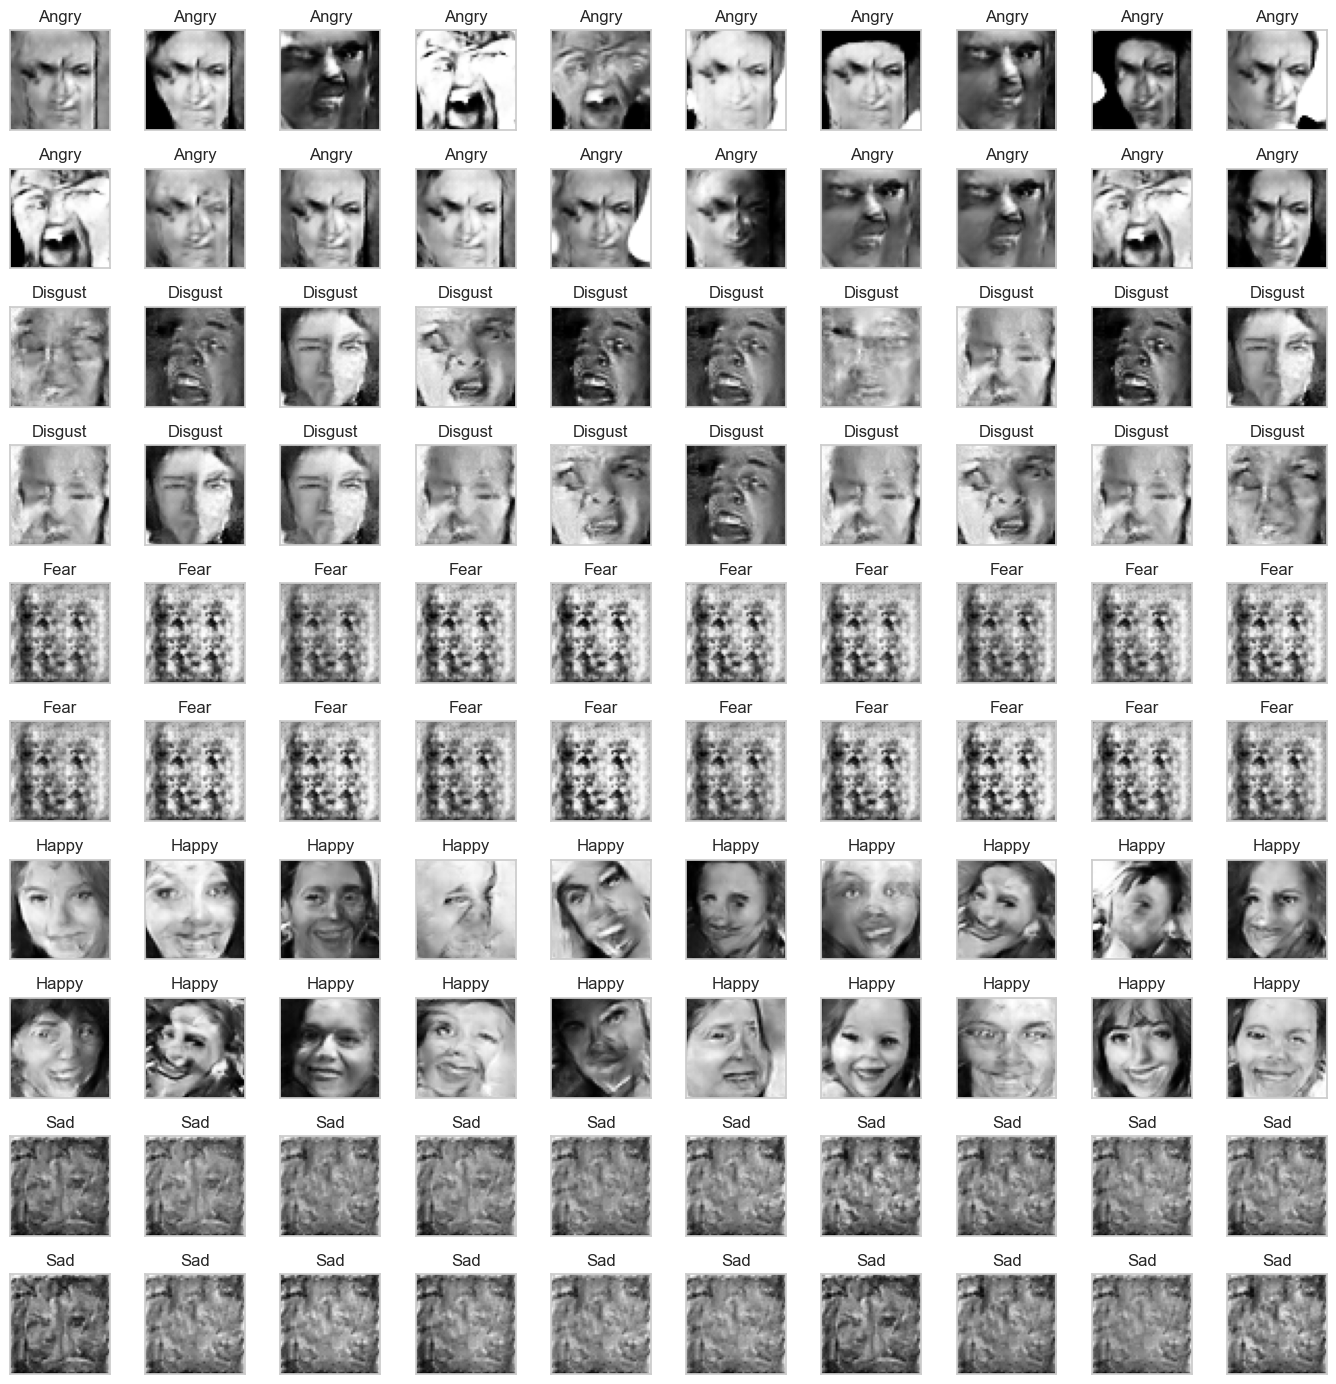

In [34]:
fig = plt.figure(1, (14, 14))
k = 0
for label, images_tensors in image_tensors.items():

    batch = images_tensors[50]
    for tensor in batch[:20]: 
        k += 1
        ax = plt.subplot(10, 10, k)
        ax.imshow(np.transpose(tensor, axes=(1,2,0)), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        plt.tight_layout()

Even after 300 epochs, the GAN seems to not have learned to generate images of the "sad" and "fear" emotion in a realistic way. "Happy" and "Anger" images are more recognizable, possibly because those emotions create preditable edges in the face (happy, with a large upturned white crescent, for a smile, for example.)

Below, we transform the generated image tensors into pixel strings, with values from 0-255, so that the images are encoded identically to the images in the original dataset.

In [24]:
labels=[]
pixel_strings=[]
for label, v in image_tensors.items():
    print(k)
    for image_tensor_batch in v:
        for tensor in image_tensor_batch: 
            image_tensor_2d = tensor[0]
            
            denormalized_tensor = (image_tensor_2d * 0.5 + 0.5) * 255  # Reverse normalization and scaling
            
            # Ensure values are in the [0, 255] range and convert to integers
            denormalized_tensor = denormalized_tensor.clamp(0, 255).to(torch.uint8)
            
            # Flatten the tensor into a 1D array
            flattened_tensor = denormalized_tensor.flatten()
            pixel_string = " ".join([str(item) for item in flattened_tensor.tolist()])
            print(pixel_string)
            labels.append(label)
            pixel_strings.append(pixel_string)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## 5. Save the images

Finally, we save the images to be used in training our model in notebook 6B. 

In [26]:
from tqdm import tqdm
images_df = pd.DataFrame(columns=["emotion", "pixels"])

for label, pixel_string in tqdm(zip(labels, pixel_strings)):
    images_df = pd.concat(
        [images_df, pd.DataFrame({"emotion": [label], "pixels": [pixel_string]})],
        ignore_index=True,
    )
images_df.to_csv("gan_images_300_epochs.csv", index=False)